In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import MNIST
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error

In [29]:
def plot_manifold(model, x, y, filesave=None):
    model.eval()
    #x = x.view(-1, 1, 28, 28)
    x_latent, _, _ = model.encode(x)
    x_latent = x_latent.detach().numpy()

    print(x_latent[:, 0].shape, x_latent[:, 1].shape, y.shape)
    plt.figure(figsize=(10, 8))
    sns.scatterplot(x=x_latent[:, 0],
                    y=x_latent[:, 1],
                    hue=y,
                    palette=sns.color_palette("hsv", 10), 
                    legend='full')
    
    plt.title('Latent space')
    plt.xlabel('Dimension 1')
    plt.ylabel('Dimension 2')
    if filesave is not None:
        plt.savefig(filesave)
    plt.show()

In [68]:
def plot_rescontruction_and_actual_images(model, x, y):
    num_images = len(np.unique(y))
    unique_labels = np.unique(y)
    plt.figure(figsize=(20, 6))
    
    x_show = []
    y_show = []
    for img, label in zip(x, y):
        if label not in y_show:
            y_show.append(label)
            x_show.append(img)
        if len(y_show) == num_images:
            break
            
    x_show_reshape = np.concatenate(x_show).reshape(-1, 28*28)
    x_reconstructed = model(torch.tensor(x_show_reshape))[0].detach()

    for i in range(num_images):
        ax = plt.subplot(2, num_images, i+1)
        plt.imshow(x_show[i].reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    
        ax = plt.subplot(2, num_images, i + 1 + num_images)
        plt.imshow(x_reconstructed[i].reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        ax.set_title(round(mean_squared_error(x_show[i].flatten(), x_reconstructed[i].flatten()), 4))
    plt.show()

In [6]:
exclude_class_0 = True

transform = transforms.ToTensor()
mnist_train = MNIST('data/', download=True, train=True, transform=transform)
mnist_test = MNIST('data/', download=True, train=False, transform=transform)

x_train = mnist_train.data[mnist_train.targets != 0]
x_test = mnist_test.data[mnist_test.targets != 0]
y_train = mnist_train.targets[mnist_train.targets != 0]
y_test = mnist_test.targets[mnist_test.targets != 0]

x_test_all = mnist_test.data.type(torch.FloatTensor) / 255.
y_test_all = mnist_test.targets

x_train = x_train.type(torch.FloatTensor) / 255.
x_test = x_test.type(torch.FloatTensor) / 255.

In [7]:
def init_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0)

In [8]:
def vae_loss(y_hat, y, mu, sigma, beta=0.0005):
    recon_loss = nn.BCELoss(reduction='mean')(y_hat, y)
    kl_loss = -beta * torch.mean(1 + sigma - mu.pow(2) - torch.exp(sigma), dim=-1)
    return torch.mean(recon_loss + kl_loss), torch.mean(recon_loss), torch.mean(kl_loss)

In [182]:
class EarlyStopping:
    def __init__(self, patience=3, delta=0.0, mode='min', verbose=True):
        """
        patience (int): loss or score가 개선된 후 기다리는 기간. default: 3
        delta  (float): 개선시 인정되는 최소 변화 수치. default: 0.0
        mode     (str): 개선시 최소/최대값 기준 선정('min' or 'max'). default: 'min'.
        verbose (bool): 메시지 출력. default: True
        """
        self.early_stop = False
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        
        self.best_score = np.Inf if mode == 'min' else 0
        self.mode = mode
        self.delta = delta
        

    def __call__(self, score):

        if self.best_score is None:
            self.best_score = score
            self.counter = 0
        elif self.mode == 'min':
            if score < (self.best_score - self.delta):
                self.counter = 0
                self.best_score = score
                if self.verbose:
                    print(f'[EarlyStopping] (Update) Best Score: {self.best_score:.5f}')
            else:
                self.counter += 1
                if self.verbose:
                    print(f'[EarlyStopping] (Patience) {self.counter}/{self.patience}, ' \
                          f'Best: {self.best_score:.5f}' \
                          f', Current: {score:.5f}, Delta: {np.abs(self.best_score - score):.5f}')
                
        elif self.mode == 'max':
            if score > (self.best_score + self.delta):
                self.counter = 0
                self.best_score = score
                if self.verbose:
                    print(f'[EarlyStopping] (Update) Best Score: {self.best_score:.5f}')
            else:
                self.counter += 1
                if self.verbose:
                    print(f'[EarlyStopping] (Patience) {self.counter}/{self.patience}, ' \
                          f'Best: {self.best_score:.5f}' \
                          f', Current: {score:.5f}, Delta: {np.abs(self.best_score - score):.5f}')
                
            
        if self.counter >= self.patience:
            if self.verbose:
                print(f'[EarlyStop Triggered] Best Score: {self.best_score:.5f}')
            # Early Stop
            self.early_stop = True
        else:
            # Continue
            self.early_stop = False

In [138]:
class VAE(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()
        input_size = 28*28
        self.encoder = self._encoder(input_size, latent_dim)
        self.mu = nn.Linear(int(input_size/4), latent_dim)
        self.sigma = nn.Linear(int(input_size/4), latent_dim)
        self.decoder = self._decoder(input_size, latent_dim)

    def _encoder(self, input_size, latent_dim):
        encoder = nn.Sequential(
            nn.Linear(input_size, int(input_size/2)),
            nn.ReLU(),
            nn.Dropout(0.9),
            nn.Linear(int(input_size/2), int(input_size/4)),
            nn.ReLU(),
            nn.Dropout(0.9),
        )
        return encoder

    def _decoder(self, input_size, latent_dim):
        decoder = nn.Sequential(
            nn.Linear(latent_dim, int(input_size/2)),
            nn.ReLU(),
            nn.Dropout(0.9),
            nn.Linear(int(input_size/2), input_size),
            nn.Sigmoid(),
        )
        return decoder

    def reparameterize(self, mu, sigma):
        return mu + torch.exp(sigma / 2.) * torch.rand_like(sigma)

    def encode(self, x,):
        encoded = self.encoder(x)
        mu = self.mu(encoded)
        sigma = self.sigma(encoded)
        return self.reparameterize(mu, sigma), mu, sigma

    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        z, mu, sigma = self.encode(x)
        return self.decoder(z), mu, sigma

In [193]:
def train(model, X, X_val, lr=0.1, optimizer='Adam', epochs=20, batch_size=128, loss='BCELoss', shuffle=True):
    optimizer = getattr(optim, optimizer)(model.parameters(), lr=lr)

    try:
        loss_fn = getattr(nn, loss)()
    except:
        loss_fn = loss

    lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=3, threshold=1e-3, verbose=True)
    es = EarlyStopping(patience=5, 
                   delta=0, 
                   mode='min', 
                   verbose=True
                  )
    model.train()
    mnist_trainset = DataLoader(X, batch_size=batch_size, shuffle=shuffle)
    mnist_validationset = DataLoader(X_val, batch_size=batch_size, shuffle=shuffle)

    for epoch in range(1, epochs+1):
        train_loss = 0.0
        batch_num = 0

        for images in mnist_trainset:
            images = images.view(images.size(0), 28*28)

            optimizer.zero_grad()
            y_hat, mu, sigma = model(images)

            loss, recon_loss, kl_loss = loss_fn(y_hat, images, mu, sigma)
            loss.backward()
            train_loss += loss.item()
            optimizer.step()

            print(f'Epoch: {epoch} [{batch_num}/{len(X)}], Loss: {loss.item()/len(images):.6f}', end='\r')
            batch_num += images.size(0)

        # validation
        model.eval()
        total_val_loss = 0.0
        with torch.no_grad():
            for i, image in enumerate(mnist_validationset):
                recon_image, mu, sigma = model(image)
                val_loss, _, _ = loss_fn(recon_image, image, mu, sigma)
                total_val_loss += val_loss
        avg_val_loss = total_val_loss / (i+1)

        lr_scheduler.step(avg_val_loss)
        es(avg_val_loss)
        if es.early_stop:
            break

        train_loss = train_loss / len(X.data)
        print(f'Epoch: {epoch} [{batch_num}/{len(X)}] - Loss: {train_loss:.6f}, validdation_loss: {avg_val_loss}, lr:{optimizer.param_groups[0]["lr"]}')

In [197]:
vae = VAE(2)
vae.apply(init_weights)

VAE(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=392, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.9, inplace=False)
    (3): Linear(in_features=392, out_features=196, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.9, inplace=False)
  )
  (mu): Linear(in_features=196, out_features=2, bias=True)
  (sigma): Linear(in_features=196, out_features=2, bias=True)
  (decoder): Sequential(
    (0): Linear(in_features=2, out_features=392, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.9, inplace=False)
    (3): Linear(in_features=392, out_features=784, bias=True)
    (4): Sigmoid()
  )
)

In [198]:
train(vae, x_train.view(-1, 28*28), x_test.view(-1, 28*28), epochs=50, lr=0.01, optimizer='Adam', loss=vae_loss, batch_size=512)

/root/.pyenv/versions/3.9.2/lib/python3.9/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


[EarlyStopping] (Update) Best Score: 0.25496
Epoch: 1 [54077/54077] - Loss: 0.000694, validdation_loss: 0.25496014952659607, lr:0.01
[EarlyStopping] (Update) Best Score: 0.21304
Epoch: 2 [54077/54077] - Loss: 0.000458, validdation_loss: 0.2130429893732071, lr:0.01
[EarlyStopping] (Update) Best Score: 0.20383
Epoch: 3 [54077/54077] - Loss: 0.000407, validdation_loss: 0.20382994413375854, lr:0.01
[EarlyStopping] (Update) Best Score: 0.19697
Epoch: 4 [54077/54077] - Loss: 0.000393, validdation_loss: 0.19696922600269318, lr:0.01
[EarlyStopping] (Update) Best Score: 0.19320
Epoch: 5 [54077/54077] - Loss: 0.000383, validdation_loss: 0.19319698214530945, lr:0.01
[EarlyStopping] (Update) Best Score: 0.19026
Epoch: 6 [54077/54077] - Loss: 0.000377, validdation_loss: 0.19026368856430054, lr:0.01
[EarlyStopping] (Update) Best Score: 0.18838
Epoch: 7 [54077/54077] - Loss: 0.000372, validdation_loss: 0.18838414549827576, lr:0.01
[EarlyStopping] (Update) Best Score: 0.18716
Epoch: 8 [54077/54077] - 

(9020,) (9020,) torch.Size([9020])


/tmp/ipykernel_1047/3254439962.py:9: UserWarning: The palette list has more values (10) than needed (9), which may not be intended.
  sns.scatterplot(x=x_latent[:, 0],


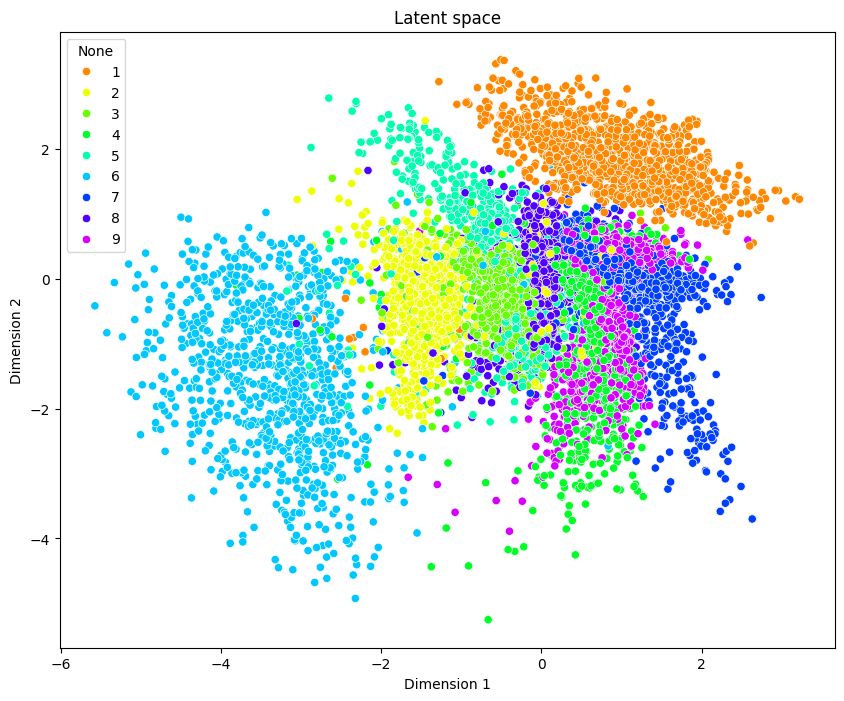

In [199]:
plot_manifold(vae, x_test.view(-1, 28*28), mnist_test.targets[mnist_test.targets != 0])

In [200]:
mse_classes = {i:[] for i in range(10)}
reconstructed_images, _, _ = vae(x_test_all.reshape(-1, 28 * 28))
for r_img, x_t, label in zip(reconstructed_images, x_test_all.reshape(-1, 28*28), y_test_all):
    mse_classes[label.item()].append(nn.MSELoss()(r_img, x_t).item())
        
avg_mse_classes = {key : np.mean(values) for key, values in mse_classes.items()}
avg_mse_classes = dict(sorted(avg_mse_classes.items(), key= lambda x: x[0]))

In [201]:
for key, value in avg_mse_classes.items():
    print('Averge mse of class {}: {}'.format(key, value))

Averge mse of class 0: 0.08318167352022565
Averge mse of class 1: 0.00977987037060807
Averge mse of class 2: 0.052100122121141054
Averge mse of class 3: 0.043064913990916595
Averge mse of class 4: 0.038948448689734134
Averge mse of class 5: 0.04506105046109568
Averge mse of class 6: 0.03660957108782546
Averge mse of class 7: 0.029957840027983376
Averge mse of class 8: 0.04671175206496975
Averge mse of class 9: 0.032813002005573896


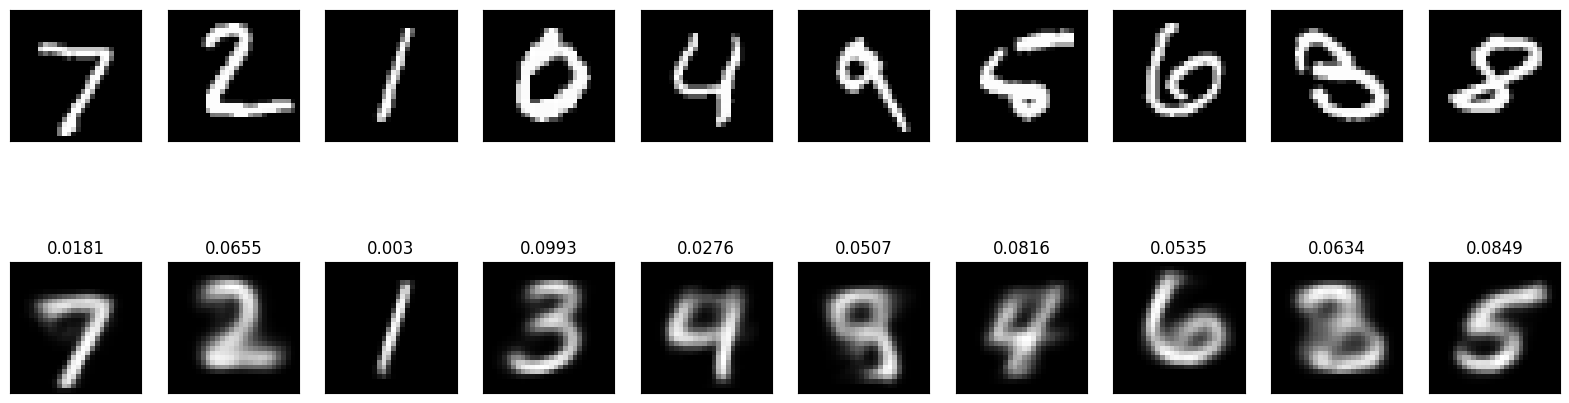

In [204]:
plot_rescontruction_and_actual_images(vae, x_test_all.data.view(-1, 28*28), y_test_all)